# Исследование объявлений о продаже квартир

В вашем распоряжении данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктов за несколько лет. Нужно научиться определять рыночную стоимость объектов недвижимости. Ваша задача — установить параметры. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность. 

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма. 

### План работы
1. Предобработка:
- Изучение данных
- Обработка выбросов
- Обработка пропущенных значений
- Корректировка типов данных
2. Анализ зависимостей:
- Добавление необходимых для анализа промежуточных столбцов
- Анализ влияние некоторых параметров на цену
3. Общий вывод

### Откройте файл с данными и изучите общую информацию. 

In [1]:
#Импортируем необходимые библиотеки
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import csv

При попытке открыть файл, оказалось, что разделитель данных в файле нестандартный. Напишу функцию для определения разделителя данных.

In [2]:
def find_delimiter(path):
    sniffer = csv.Sniffer()
    with open(path) as fp:
        delimiter = sniffer.sniff(fp.read(5000)).delimiter
    return delimiter
find_delimiter('/datasets/real_estate_data.csv')

'\t'

Разделитель '\t' определен. Прочитаем данные.

In [3]:
# Включим отображение всех столбцоы в датафрейме
pd.set_option('max_columns', None)

In [4]:
# прочитаем данные
data=pd.read_csv('/datasets/real_estate_data.csv', sep='\t')
# Создадим копию данных для сравнения в итоге
data_init=data.copy(deep=True)
data.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.0,2019-03-07T00:00:00,3,2.70,16.0,51.0,8,NaN,False,False,25.0,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.4,2018-12-04T00:00:00,1,NaN,11.0,18.6,1,NaN,False,False,11.0,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.0,2015-08-20T00:00:00,2,NaN,5.0,34.3,4,NaN,False,False,8.3,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.0,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,NaN,False,False,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.0,2018-06-19T00:00:00,2,3.03,14.0,32.0,13,NaN,False,False,41.0,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0


Данные состоят из следующих столбцов:<br>
    `airports_nearest` — расстояние до ближайшего аэропорта в метрах (м) <br>
    `balcony` — число балконов<br>
    `ceiling_height` — высота потолков (м)<br>
    `cityCenters_nearest` — расстояние до центра города (м)<br>
    `days_exposition` — сколько дней было размещено объявление (от публикации до снятия)<br>
    `first_day_exposition` — дата публикации<br>
    `floor` — этаж<br>
    `floors_total` — всего этажей в доме<br>
    `is_apartment` — апартаменты (булев тип)<br>
    `kitchen_area` — площадь кухни в квадратных метрах (м²)<br>
    `last_price` — цена на момент снятия с публикации<br>
    `living_area` — жилая площадь в квадратных метрах (м²)<br>
    `locality_name` — название населённого пункта<br>
    `open_plan` — свободная планировка (булев тип)<br>
    `parks_around3000` — число парков в радиусе 3 км<br>
    `parks_nearest` — расстояние до ближайшего парка (м)<br>
    `ponds_around3000` — число водоёмов в радиусе 3 км<br>
    `ponds_nearest` — расстояние до ближайшего водоёма (м)<br>
    `rooms` — число комнат<br>
    `studio` — квартира-студия (булев тип)<br>
    `total_area` — общая площадь квартиры в квадратных метрах (м²)<br>
    `total_images` — число фотографий квартиры в объявлении

In [5]:
# посмотрим общую информацию о датасете
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

In [6]:
# Посмотрим сколько пропущенных значений в датасете

print('% пропущенных значений: {:.0%}'.format(data.isnull().sum().sum()/data.isnull().count().sum()))

% пропущенных значений: 19%


In [7]:
# Посмотрим, есть ли явные дубликаты
data.duplicated().sum()

0

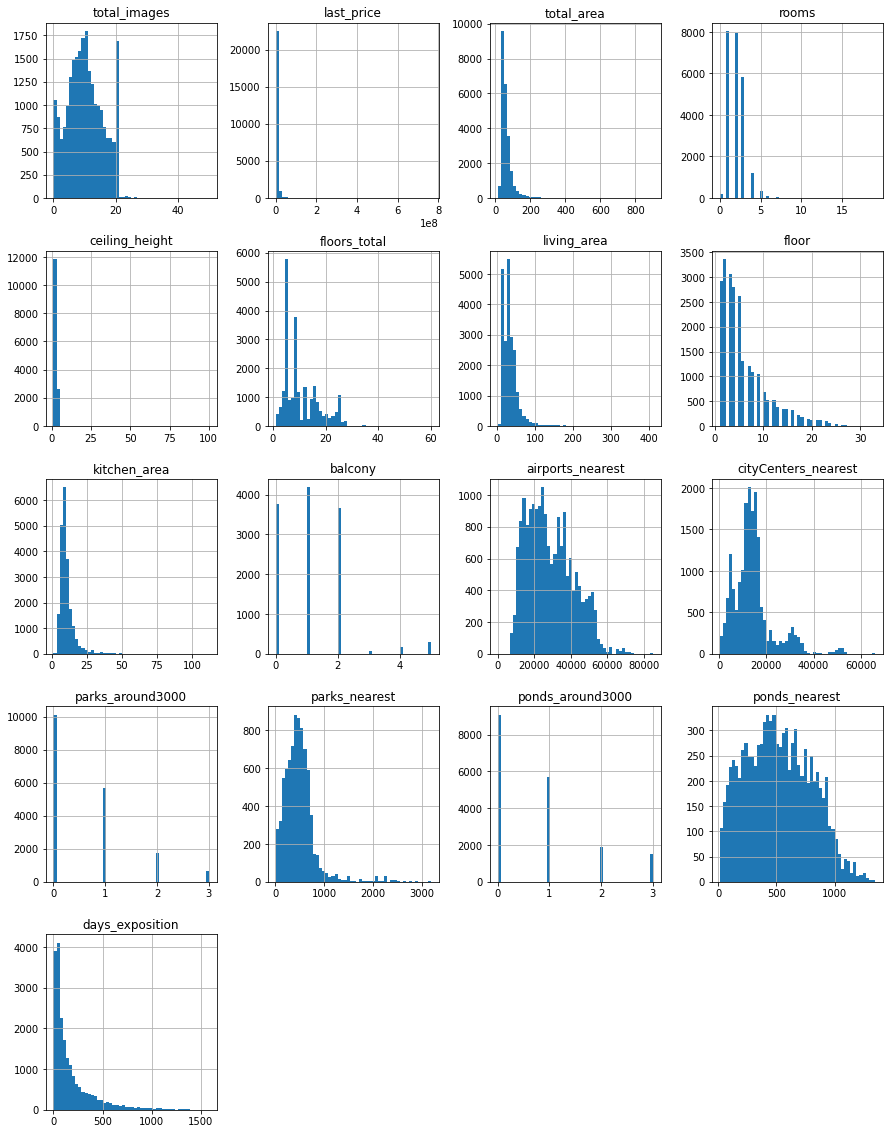

In [8]:
# Построим гистограммы для количественных параметров

data.hist(figsize=(15, 20), bins=50)
plt.show()

Вывод: Датасет состоит из 22 столбцов, 23699 строк. В данных много (19%) пропущенных значений. Явных дубликатов нет. Типы данных требуют детальной проверки, так как уже сейчас заметны несостыковки. Например, булевый столбец "is_apartment" имеет тип данных object, "ponds_around3000" по логике должен быть целочисленным, а по факту имеет тип данных float64 и т.д.

### Предобработка данных

Мы выяснили, что у нас много пропусков в датасете. Попробуем заполнить их, где это возможно

In [9]:
# Посмотрим, в каких конкретно столбцах есть пропуски

(data.isnull().sum()/data.isnull().count()).transform(lambda x: '{:,.2%}'.format(x))

total_images             0.00%
last_price               0.00%
total_area               0.00%
first_day_exposition     0.00%
rooms                    0.00%
ceiling_height          38.80%
floors_total             0.36%
living_area              8.03%
floor                    0.00%
is_apartment            88.29%
studio                   0.00%
open_plan                0.00%
kitchen_area             9.61%
balcony                 48.61%
locality_name            0.21%
airports_nearest        23.38%
cityCenters_nearest     23.29%
parks_around3000        23.28%
parks_nearest           65.91%
ponds_around3000        23.28%
ponds_nearest           61.56%
days_exposition         13.42%
dtype: object

#### **last_price**

Наша самая главная и целевая переменная - цена продажи. Поэтому ее нужно детально изучить, и при необходимости обработать аномалии.

In [10]:
data['last_price'].describe()

count    2.369900e+04
mean     6.541549e+06
std      1.088701e+07
min      1.219000e+04
25%      3.400000e+06
50%      4.650000e+06
75%      6.800000e+06
max      7.630000e+08
Name: last_price, dtype: float64

<AxesSubplot:ylabel='Frequency'>

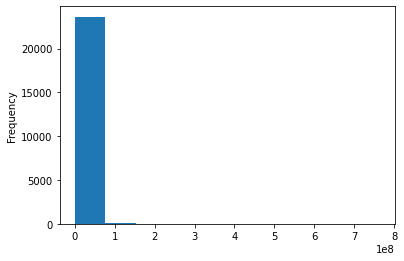

In [11]:
data['last_price'].plot(kind='hist')

Можно заметить, что максимальная цена измеряется в сотнях миллионов, а 75% всех значений цен меньше 7 млн руб. Я считаю, что для исследования нужно убрать очень дорогие квартиры, так как в выборке их очень мало, качественный анализ их ценообразования все равно не выйдет.

In [12]:
#Посмотрим 0,5% самых дорогих квартир
data['last_price'].quantile(0.995)

54509999.9999984

In [13]:
data[data['last_price']>54755000]

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
3,0,64900000.0,159.0,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,NaN,False,False,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
155,8,96000000.0,317.0,2017-07-07T00:00:00,4,3.50,3.0,183.0,3,NaN,False,False,NaN,1.0,Санкт-Петербург,22673.0,1771.0,2.0,508.0,3.0,366.0,62.0
464,15,66571000.0,280.3,2015-06-11T00:00:00,6,5.20,8.0,159.5,7,NaN,False,False,21.1,0.0,Санкт-Петербург,26316.0,6655.0,3.0,187.0,1.0,616.0,578.0
492,18,95000000.0,216.0,2017-12-05T00:00:00,4,3.00,5.0,86.0,4,NaN,False,False,77.0,NaN,Санкт-Петербург,21740.0,436.0,2.0,138.0,3.0,620.0,14.0
509,5,90000000.0,225.0,2016-06-26T00:00:00,6,NaN,4.0,134.0,2,NaN,False,False,19.5,2.0,Санкт-Петербург,32864.0,5720.0,0.0,NaN,2.0,519.0,416.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22709,20,59000000.0,127.5,2016-12-21T00:00:00,4,3.00,12.0,85.0,8,NaN,False,False,13.0,1.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,635.0
22804,4,81960000.0,205.0,2017-09-29T00:00:00,4,3.20,9.0,108.0,3,NaN,False,False,10.0,NaN,Санкт-Петербург,21946.0,2242.0,1.0,679.0,1.0,227.0,169.0
22831,18,289238400.0,187.5,2019-03-19T00:00:00,2,3.37,6.0,63.7,6,NaN,False,False,30.2,NaN,Санкт-Петербург,22494.0,1073.0,3.0,386.0,3.0,188.0,NaN
22907,9,65000000.0,228.0,2016-06-02T00:00:00,4,NaN,5.0,200.0,2,NaN,False,False,NaN,NaN,Санкт-Петербург,22783.0,1295.0,3.0,619.0,3.0,269.0,NaN


Всего 119, менее 1%, значений, которые измеряются в десятках и сотнях миллионов. Удалим их из выборки, чтобы э ти значения не влияли на среднюю рыночную цену. Это элитное жилье, ценообразование которого формируется иначе, чем обычного жилья.

In [14]:
data=data.drop(labels=data[data['last_price']>54755000].index, axis=0)

Меня смущает минимальное значение стоимость квартир. Предполагаю, что это ошибка. Изучим 1 процентиль.

In [15]:
data['last_price'].quantile(0.005)

800000.0

In [16]:
data[data['last_price']<800000]

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
247,7,650000.0,31.0,2017-01-20T00:00:00,1,NaN,3.0,NaN,1,NaN,False,False,NaN,NaN,Сланцы,NaN,NaN,NaN,NaN,NaN,NaN,378.0
268,7,650000.0,46.0,2018-03-15T00:00:00,2,2.5,5.0,30.0,5,NaN,False,False,7.0,NaN,Сланцы,NaN,NaN,NaN,NaN,NaN,NaN,75.0
606,5,790000.0,38.6,2018-04-03T00:00:00,2,3.0,2.0,24.0,1,NaN,False,False,6.0,NaN,поселок городского типа Синявино,NaN,NaN,NaN,NaN,NaN,NaN,374.0
1053,13,550000.0,29.0,2018-02-01T00:00:00,1,5.0,3.0,NaN,1,False,False,False,NaN,NaN,Бокситогорск,NaN,NaN,NaN,NaN,NaN,NaN,6.0
1312,5,750000.0,26.0,2018-02-03T00:00:00,1,2.5,2.0,18.0,1,NaN,False,False,6.0,NaN,поселок городского типа Вырица,NaN,NaN,NaN,NaN,NaN,NaN,167.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22997,9,560000.0,28.5,2018-08-11T00:00:00,1,2.6,4.0,17.2,4,NaN,False,False,5.7,1.0,Пикалёво,NaN,NaN,NaN,NaN,NaN,NaN,198.0
23067,8,600000.0,31.8,2019-04-24T00:00:00,1,NaN,2.0,20.0,1,NaN,False,False,7.0,NaN,деревня Коркино,NaN,NaN,NaN,NaN,NaN,NaN,NaN
23153,9,650000.0,41.0,2017-10-13T00:00:00,2,NaN,3.0,28.0,1,NaN,False,False,6.0,0.0,Бокситогорск,NaN,NaN,NaN,NaN,NaN,NaN,14.0
23484,11,470000.0,44.5,2018-07-02T00:00:00,2,NaN,2.0,28.0,2,NaN,False,False,7.5,NaN,Сланцы,NaN,NaN,NaN,NaN,NaN,NaN,298.0


In [17]:
data[data['last_price']<1000000]['total_area'].describe()

count    225.000000
mean      41.832711
std       11.913653
min       18.000000
25%       32.000000
50%       41.000000
75%       47.200000
max      109.000000
Name: total_area, dtype: float64

In [18]:
data[data['last_price']<1000000]['locality_name'].value_counts().head(20)

Сланцы                                83
Бокситогорск                          14
Пикалёво                              11
Ивангород                              5
Кириши                                 4
поселок городского типа Никольский     4
Луга                                   4
Выборг                                 4
посёлок городского типа Важины         3
посёлок городского типа Кузнечное      3
Подпорожье                             3
поселок городского типа Ефимовский     3
деревня Старополье                     3
деревня Торошковичи                    3
Волхов                                 3
поселок станции Вещево                 2
деревня Выскатка                       2
поселок Серебрянский                   2
поселок Оредеж                         2
посёлок станции Свирь                  2
Name: locality_name, dtype: int64

Стоимость квартир менее 1 млн руб сейчас, конечно, вообще вывглядит нереально, но в 2015-2016 гг в станицах, поселках и деревнях, еще учитывая маленькую площадь квартиры (в среднем 41кв.м), похоже на правду.

<AxesSubplot:ylabel='Frequency'>

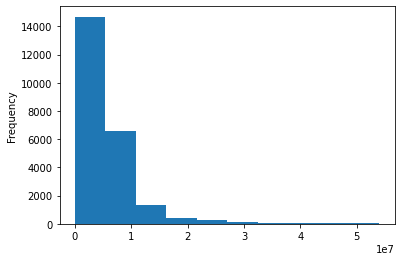

In [19]:
# Посмотрим на гистограмму после обработки
data['last_price'].plot(kind='hist')

Картина уже намного лучше, большинство квартир дешевле 10 млн. руб.

#### **Ceiling_height**

В столбце ceiling_height много пропусков - 39%. Вероятно этот показатель заполняется вручную. <br>
Выведем описание данного параметра

In [20]:
data['ceiling_height'].describe()

count    14426.000000
mean         2.767297
std          1.262234
min          1.000000
25%          2.510000
50%          2.650000
75%          2.800000
max        100.000000
Name: ceiling_height, dtype: float64

Медианное значение выглядит достаточно нормальным. Но минимальное и максимальное значения вообще не похожи на правду. Изучим гистограмму значений.

<AxesSubplot:ylabel='Frequency'>

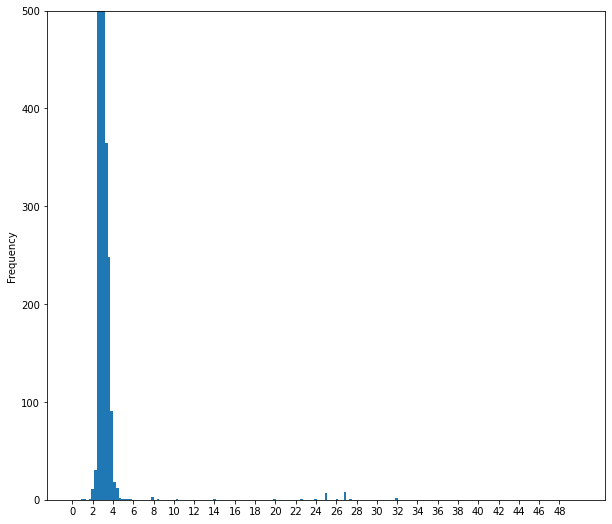

In [21]:
data['ceiling_height'].plot(kind='hist', figsize=(10,9), ylim=(0,500), bins=187, xticks=np.arange(0,50,2), range=(0,50))

Гистограмма еще раз подтверждает, что основном параметр высота потолков находится в промежутке примерно от 2 до 4 метров. Виден небольшой всплеск значений примерно от 25 до 28, что больше похоже на то, что пользователь забыл поставить запятую между цифрами.Исправим это.

In [22]:
data.loc[(data['ceiling_height']>=25)&(data['ceiling_height']<=28),['ceiling_height']]=data['ceiling_height']/10

Значения меньше 2,5 и больше 4 м будем считать аномальными. Замени аномальные и пропущенные значения на медианные значения.

In [23]:
data.loc[(data['ceiling_height'].isna())|(data['ceiling_height']<2.5)|(data['ceiling_height']>4),['ceiling_height']]=data['ceiling_height'].median()

In [24]:
# проверим
data['ceiling_height'].isna().sum()

0

<AxesSubplot:ylabel='Frequency'>

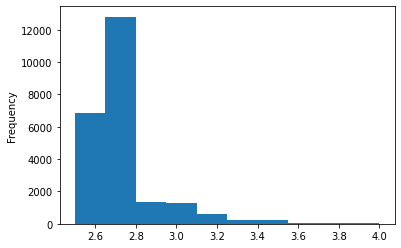

In [25]:
# Изучим гистограмму
data['ceiling_height'].plot(kind='hist')

Параметр `ceiling_height` выглядит адекватно

#### **floors_total**

Меньше 1% пропущенных значений. Скорее всего показатель заполняется вручную и возможно клиенты забыли этажность дома при внесении информации. Может они покупали эти квартиры как инвестиции, не жили в них, поэтому информация могла вылететь из головы.

Посмотрим на описание и гистограмму

In [26]:
data['floors_total'].describe()

count    23494.000000
mean        10.691155
std          6.605299
min          1.000000
25%          5.000000
50%          9.000000
75%         16.000000
max         60.000000
Name: floors_total, dtype: float64

<AxesSubplot:>

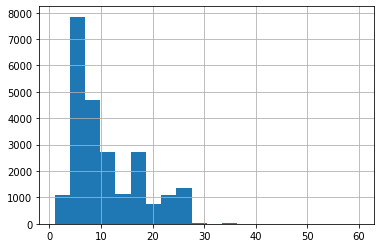

In [27]:
data['floors_total'].hist(bins=20)

В основном в выборке присутствуют квартиры, которые продаются в многоэтажных домах не выше 10 этажей.

Пропущенных значений крайне мало, удалим их, чтобы не потерять качество данных, а также изменим тип на целочисленный.

In [28]:
data=data.drop(labels=data[data['floors_total'].isna()].index, axis=0)
data['floors_total']=data['floors_total'].astype('int')

#### **living_area** 

В данном параметре 8% пропущенных значений, не мало. Видимо данный показатель также заполняется вручную. Изучим описание данного параметра.

In [29]:
data['living_area'].describe()

count    21640.000000
mean        33.924316
std         19.977145
min          2.000000
25%         18.600000
50%         30.000000
75%         42.100000
max        332.000000
Name: living_area, dtype: float64

Все значения, кроме мин и ст. отклонения выглядят реальными. Минимальное значение уж очень маленькое, а стандартное отклонение очень большое. Изучим гистограмму.

<AxesSubplot:ylabel='Frequency'>

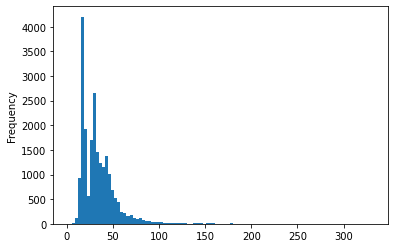

In [30]:
data['living_area'].plot(kind='hist', bins=100)

Гистограмма подтверждает, что большая часть квартир жилой площадью до 50 кв.м. <br>
Немного, однако есть квартиры с жилой площадью более 50 кв м. Видимо этото факт повлиял на формирование большого ст. отклонения.
Очевидно, что `living_area` зависит от параметра `total_area`, буду заменять пропущенные значения исходя из соотношения медианной общей площади к медианной жилой

In [31]:
# Найдем соотношение общей медианной площади к медианной жилой
living_total_area_ratio=data['living_area'].median()/data['total_area'].median()
living_total_area_ratio

0.5769230769230769

In [32]:
# Для проверки сохраним индексы пропущенных значений
data_isna_index=data[data['living_area'].isna()].index
data_isna_index

Int64Index([    7,    30,    37,    44,    59,    60,    81,    82,   116,
              133,
            ...
            23601, 23602, 23607, 23613, 23632, 23642, 23663, 23670, 23679,
            23697],
           dtype='int64', length=1854)

In [33]:
# Заполним пропуски
data['living_area']=data['living_area'].fillna(data['total_area'] * living_total_area_ratio)        

In [34]:
# Посмотрим на результат
data.loc[data_isna_index]

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
7,5,7915000.0,71.60,2019-04-18T00:00:00,2,2.65,24,41.307692,22,NaN,False,False,18.9,2.0,Санкт-Петербург,23982.0,11634.0,0.0,NaN,0.0,NaN,NaN
30,12,2200000.0,32.80,2018-02-19T00:00:00,1,2.65,9,18.923077,2,NaN,False,False,NaN,NaN,Коммунар,NaN,NaN,NaN,NaN,NaN,NaN,63.0
37,10,1990000.0,45.80,2017-10-28T00:00:00,2,2.50,5,26.423077,1,NaN,False,False,NaN,NaN,поселок городского типа Красный Бор,NaN,NaN,NaN,NaN,NaN,NaN,196.0
44,13,5350000.0,40.00,2018-11-18T00:00:00,1,2.65,22,23.076923,3,NaN,False,False,NaN,1.0,Санкт-Петербург,30471.0,11603.0,1.0,620.0,1.0,1152.0,NaN
59,15,6300000.0,46.50,2017-03-06T00:00:00,1,2.65,13,26.826923,13,NaN,False,False,NaN,NaN,Санкт-Петербург,11125.0,14501.0,0.0,NaN,0.0,NaN,336.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23642,14,5950000.0,80.30,2018-07-03T00:00:00,3,2.70,12,46.326923,5,NaN,False,False,NaN,NaN,Колпино,27933.0,33719.0,0.0,NaN,2.0,562.0,60.0
23663,12,6400000.0,88.00,2018-01-12T00:00:00,4,2.55,10,50.769231,1,NaN,False,False,NaN,NaN,Санкт-Петербург,33642.0,13943.0,0.0,NaN,2.0,844.0,59.0
23670,9,2450000.0,45.60,2018-02-08T00:00:00,1,2.80,9,26.307692,2,NaN,False,False,NaN,NaN,поселок городского типа Синявино,NaN,NaN,NaN,NaN,NaN,NaN,45.0
23679,0,2500000.0,35.00,2017-12-08T00:00:00,1,2.65,9,20.192308,4,NaN,False,False,NaN,NaN,Сосновый Бор,NaN,NaN,NaN,NaN,NaN,NaN,45.0


#### **is_apartment** 

В данном параметре 88% пропущенных значений, что скорее всего означает, что квартира не является апартаментами. Эти пропущенные значения следует заменить на ноль.

In [35]:
# Посмотрим состав данного параметра
data['is_apartment'].describe()

count      2759
unique        2
top       False
freq       2711
Name: is_apartment, dtype: object

In [36]:
data['is_apartment']=data['is_apartment'].fillna(0)

Данный параметр имеет неправильный тип данных - object, нужно заменить на булевый.

In [37]:
data['is_apartment'] = data['is_apartment'].astype('bool')

#### **kitchen_area** 

В данном параметре 10% пропущенных значений, не мало. Видимо данный показатель также заполняется вручную. Изучим описание данного параметра.

In [38]:
data['kitchen_area'].describe()

count    21281.000000
mean        10.446085
std          5.444296
min          1.300000
25%          7.000000
50%          9.090000
75%         12.000000
max        100.700000
Name: kitchen_area, dtype: float64

Описание выглядит вполне нормально. Смущает только кухня размером 1,3 кв.м. Посмотрим

In [39]:
data[data['kitchen_area']==1.3]

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
20217,7,4250000.0,28.5,2019-05-01T00:00:00,1,2.8,14,19.5,10,False,False,False,1.3,NaN,Санкт-Петербург,37199.0,12721.0,0.0,NaN,0.0,NaN,NaN


Это однокомнатная квартира с маленькой кухней и достаточной большой гостиной. Судя по всему в этой квартире кухня совмещена с гостиной.

Посмотрим на гистограмму параметра

<AxesSubplot:ylabel='Frequency'>

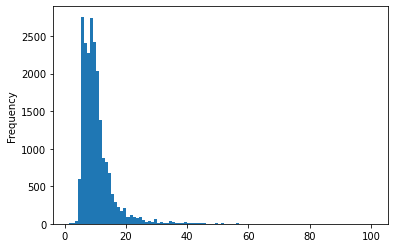

In [40]:
data['kitchen_area'].plot(kind='hist', bins=100)

В основном кухни не превышают 20 кв. м, лишь небольшая часть больше.

Пропуски в данном параметре планирую заполнять аналогично `living_area`.

In [41]:
# Найдем соотношение общей медианной площади к медианной площади кухни
kitchen_total_area_ratio=data['kitchen_area'].median()/data['total_area'].median()
kitchen_total_area_ratio

0.1748076923076923

In [42]:
# Для проверки сохраним индексы пропущенных значений
data_isna_index=data[data['kitchen_area'].isna()].index
data_isna_index

Int64Index([   30,    37,    44,    59,    60,    81,    82,   133,   144,
              164,
            ...
            23607, 23613, 23632, 23637, 23642, 23655, 23663, 23670, 23679,
            23696],
           dtype='int64', length=2213)

In [43]:
# Заполним пропуски
data['kitchen_area']=data['kitchen_area'].fillna(data['total_area'] * kitchen_total_area_ratio)      

In [44]:
# Посмотрим на результат
data.loc[data_isna_index]

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
30,12,2200000.0,32.8,2018-02-19T00:00:00,1,2.65,9,18.923077,2,False,False,False,5.733692,NaN,Коммунар,NaN,NaN,NaN,NaN,NaN,NaN,63.0
37,10,1990000.0,45.8,2017-10-28T00:00:00,2,2.50,5,26.423077,1,False,False,False,8.006192,NaN,поселок городского типа Красный Бор,NaN,NaN,NaN,NaN,NaN,NaN,196.0
44,13,5350000.0,40.0,2018-11-18T00:00:00,1,2.65,22,23.076923,3,False,False,False,6.992308,1.0,Санкт-Петербург,30471.0,11603.0,1.0,620.0,1.0,1152.0,NaN
59,15,6300000.0,46.5,2017-03-06T00:00:00,1,2.65,13,26.826923,13,False,False,False,8.128558,NaN,Санкт-Петербург,11125.0,14501.0,0.0,NaN,0.0,NaN,336.0
60,3,2740000.0,35.0,2018-01-01T00:00:00,1,2.65,12,20.192308,8,False,False,False,6.118269,NaN,посёлок Мурино,NaN,NaN,NaN,NaN,NaN,NaN,11.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23655,1,2414306.0,40.5,2016-09-08T00:00:00,1,2.56,18,19.600000,10,False,False,False,7.079712,NaN,Никольское,NaN,NaN,NaN,NaN,NaN,NaN,627.0
23663,12,6400000.0,88.0,2018-01-12T00:00:00,4,2.55,10,50.769231,1,False,False,False,15.383077,NaN,Санкт-Петербург,33642.0,13943.0,0.0,NaN,2.0,844.0,59.0
23670,9,2450000.0,45.6,2018-02-08T00:00:00,1,2.80,9,26.307692,2,False,False,False,7.971231,NaN,поселок городского типа Синявино,NaN,NaN,NaN,NaN,NaN,NaN,45.0
23679,0,2500000.0,35.0,2017-12-08T00:00:00,1,2.65,9,20.192308,4,False,False,False,6.118269,NaN,Сосновый Бор,NaN,NaN,NaN,NaN,NaN,NaN,45.0


#### **balcony** 

Предполагаю, что пропущенные значения в данном столбце означает отсутствие балкона. Видимо данные вносились пользователем. Изучим описание и гистограмму

In [45]:
data['balcony'].describe()

count    12075.000000
mean         1.156025
std          1.070485
min          0.000000
25%          0.000000
50%          1.000000
75%          2.000000
max          5.000000
Name: balcony, dtype: float64

<AxesSubplot:ylabel='Frequency'>

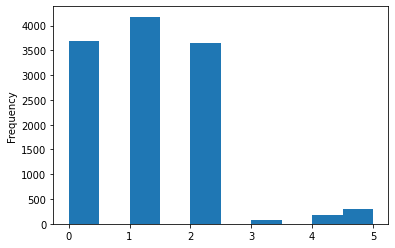

In [46]:
data['balcony'].plot(kind='hist')

В осномном квартиры с 0 максимум до 2 балконами. Небольшая часть квартир имеет более 2 балконов.
Заменим пропущенные значения, а также изменим тип данных на целочисленный.

In [47]:
data['balcony']=data['balcony'].fillna(0)

In [48]:
data['balcony'] = data['balcony'].astype('int')

#### **locality_name**  

Это важный параметр, в котором мы не можем допустить искажение данных, поэтому строки, в которых пропущены значения предлагаю удалить.

Изучим описание гистограмму

In [49]:
data['locality_name'].describe()

count               23446
unique                364
top       Санкт-Петербург
freq                15532
Name: locality_name, dtype: object

<AxesSubplot:xlabel='locality_name'>

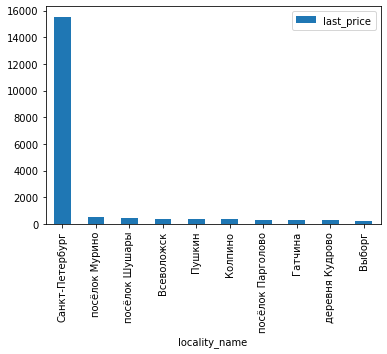

In [50]:
data.pivot_table(index='locality_name', values='last_price', aggfunc='count').sort_values(by='last_price', ascending=False).head(10).plot(kind='bar')

Сразу понятно, что болшинство квартир в выборке в Санкт-Петербурге, а всего 364 населеных пункта, в которых продаются квартиры.

In [51]:
data['locality_name'].isna().sum()

48

In [52]:
# Удалим строки, в которых пропущены название местности. Всего их 49 штук, что менее 1% от общей выборки
data=data.drop(labels=data[data['locality_name'].isna()].index, axis=0)

In [53]:
# Изучим данный параметр на предмет неявных дубликатов
data['locality_name'].sort_values().unique()

array(['Бокситогорск', 'Волосово', 'Волхов', 'Всеволожск', 'Выборг',
       'Высоцк', 'Гатчина', 'Зеленогорск', 'Ивангород', 'Каменногорск',
       'Кингисепп', 'Кириши', 'Кировск', 'Колпино', 'Коммунар',
       'Красное Село', 'Кронштадт', 'Кудрово', 'Лодейное Поле',
       'Ломоносов', 'Луга', 'Любань', 'Мурино', 'Никольское',
       'Новая Ладога', 'Отрадное', 'Павловск', 'Петергоф', 'Пикалёво',
       'Подпорожье', 'Приморск', 'Приозерск', 'Пушкин', 'Санкт-Петербург',
       'Светогорск', 'Сертолово', 'Сестрорецк', 'Сланцы', 'Сосновый Бор',
       'Сясьстрой', 'Тихвин', 'Тосно', 'Шлиссельбург',
       'городской поселок Большая Ижора', 'городской поселок Янино-1',
       'городской посёлок Будогощь', 'городской посёлок Виллози',
       'городской посёлок Лесогорский', 'городской посёлок Мга',
       'городской посёлок Назия', 'городской посёлок Новоселье',
       'городской посёлок Павлово', 'городской посёлок Рощино',
       'городской посёлок Свирьстрой', 'городской посёлок Совет

In [54]:
len(data['locality_name'].sort_values().unique())

364

Дубликаты здесь точно есть. Создадим функцию для их обработки

In [55]:
# создайте функцию categorize_purpose()
def duplicates_processing(row):
    
    if 'поселок городского типа' in row['locality_name']:
        return row['locality_name'].replace('поселок городского типа', 'городской посёлок')
    if 'посёлок городского типа' in row['locality_name']:
        return row['locality_name'].replace('посёлок городского типа', 'городской посёлок')
    if 'поселок' in row['locality_name']: 
        return row['locality_name'].replace('поселок', 'посёлок')
    return row['locality_name']
    

In [56]:
# примените функцию методом apply()
data['locality_name']=data.apply(duplicates_processing, axis=1)

In [57]:
# Изучим данный параметр на предмет неявных дубликатов
data['locality_name'].sort_values().unique()

array(['Бокситогорск', 'Волосово', 'Волхов', 'Всеволожск', 'Выборг',
       'Высоцк', 'Гатчина', 'Зеленогорск', 'Ивангород', 'Каменногорск',
       'Кингисепп', 'Кириши', 'Кировск', 'Колпино', 'Коммунар',
       'Красное Село', 'Кронштадт', 'Кудрово', 'Лодейное Поле',
       'Ломоносов', 'Луга', 'Любань', 'Мурино', 'Никольское',
       'Новая Ладога', 'Отрадное', 'Павловск', 'Петергоф', 'Пикалёво',
       'Подпорожье', 'Приморск', 'Приозерск', 'Пушкин', 'Санкт-Петербург',
       'Светогорск', 'Сертолово', 'Сестрорецк', 'Сланцы', 'Сосновый Бор',
       'Сясьстрой', 'Тихвин', 'Тосно', 'Шлиссельбург',
       'городской посёлок Большая Ижора', 'городской посёлок Будогощь',
       'городской посёлок Важины', 'городской посёлок Виллози',
       'городской посёлок Вознесенье', 'городской посёлок Вырица',
       'городской посёлок Дружная Горка', 'городской посёлок Дубровка',
       'городской посёлок Ефимовский', 'городской посёлок Кондратьево',
       'городской посёлок Красный Бор', 'городс

In [58]:
len(data['locality_name'].sort_values().unique())

323

Убрали 41 дубликат

#### **airports_nearest** 

Параметр расстояние до ближайшего аэропорта явно заполняется автоматически. 23% пропущенных значений это много, очевидно, что произошла какая-то техническая ошибка либо при выгрузке данных, либо при записи. В других параметрах также есть примерно столько же пропущенных значений. Посмотрим на срез данных:

In [59]:
print('Индексы строк, в которых пропущены значения в airports_nearest: \n',data[data['airports_nearest'].isna()].index)

Индексы строк, в которых пропущены значения в airports_nearest: 
 Int64Index([    5,     8,    12,    22,    30,    37,    38,    47,    60,
               62,
            ...
            23666, 23670, 23677, 23679, 23682, 23683, 23692, 23695, 23696,
            23698],
           dtype='int64', length=5520)


In [60]:
print('Индексы строк, в которых пропущены значения в cityCenters_nearest: \n', data[data['cityCenters_nearest'].isna()].index)

Индексы строк, в которых пропущены значения в cityCenters_nearest: 
 Int64Index([    5,     8,    12,    22,    30,    37,    38,    47,    60,
               62,
            ...
            23666, 23670, 23677, 23679, 23682, 23683, 23692, 23695, 23696,
            23698],
           dtype='int64', length=5499)


In [61]:
print('Индексы строк, в которых пропущены значения в parks_around3000: \n', data[data['parks_around3000'].isna()].index)

Индексы строк, в которых пропущены значения в parks_around3000: 
 Int64Index([    5,     8,    12,    22,    30,    37,    38,    47,    60,
               62,
            ...
            23666, 23670, 23677, 23679, 23682, 23683, 23692, 23695, 23696,
            23698],
           dtype='int64', length=5498)


In [62]:
data[data['airports_nearest'].isna()]

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
5,10,2890000.0,30.40,2018-09-10T00:00:00,1,2.65,12,14.400000,5,False,False,False,9.100000,0,городской посёлок Янино-1,NaN,NaN,NaN,NaN,NaN,NaN,55.0
8,20,2900000.0,33.16,2018-05-23T00:00:00,1,2.65,27,15.430000,26,False,False,False,8.810000,0,посёлок Мурино,NaN,NaN,NaN,NaN,NaN,NaN,189.0
12,10,3890000.0,54.00,2016-06-30T00:00:00,2,2.65,5,30.000000,5,False,False,False,9.000000,0,Сертолово,NaN,NaN,NaN,NaN,NaN,NaN,90.0
22,20,5000000.0,58.00,2017-04-24T00:00:00,2,2.75,25,30.000000,15,False,False,False,11.000000,2,деревня Кудрово,NaN,NaN,NaN,NaN,NaN,NaN,60.0
30,12,2200000.0,32.80,2018-02-19T00:00:00,1,2.65,9,18.923077,2,False,False,False,5.733692,0,Коммунар,NaN,NaN,NaN,NaN,NaN,NaN,63.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23683,16,2100000.0,62.80,2018-09-18T00:00:00,4,2.50,5,45.500000,3,False,False,False,5.500000,0,посёлок Дзержинского,NaN,NaN,NaN,NaN,NaN,NaN,NaN
23692,2,1350000.0,30.00,2017-07-07T00:00:00,1,2.65,5,17.500000,4,False,False,False,6.000000,0,Тихвин,NaN,NaN,NaN,NaN,NaN,NaN,413.0
23695,14,3100000.0,59.00,2018-01-15T00:00:00,3,2.65,5,38.000000,4,False,False,False,8.500000,0,Тосно,NaN,NaN,NaN,NaN,NaN,NaN,45.0
23696,18,2500000.0,56.70,2018-02-11T00:00:00,2,2.65,3,29.700000,1,False,False,False,9.911596,0,село Рождествено,NaN,NaN,NaN,NaN,NaN,NaN,NaN


По нескольким параметрам можно заметить, что индексы строк, в которых пропущены значения, в основном совпадают, значит это точно техническая ошибка. Нужно доложить итишникам.

Вернемся к `airports_nearest` и посмотрим его описание и гистограмму

In [63]:
data['airports_nearest'].describe()

count    17926.000000
mean     28812.339618
std      12666.674622
min          0.000000
25%      18519.000000
50%      26770.500000
75%      37347.000000
max      84869.000000
Name: airports_nearest, dtype: float64

<AxesSubplot:ylabel='Frequency'>

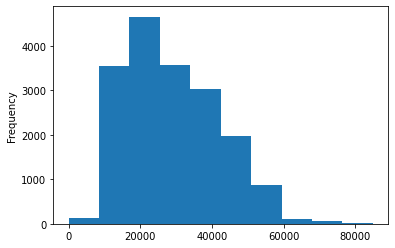

In [64]:
data['airports_nearest'].plot(kind='hist')

Разброс значений достаточно велик. Думаю будет лучше и нагляднее перевести измерение этого столбец в км и округлить до ближайшего целого. Пропущенные значения планирую оставить как есть, чтобы не ухудшать качество анализа.

In [65]:
# округлим до целого км
data['airports_nearest']=(data['airports_nearest']/1000).round(0)

<AxesSubplot:ylabel='Frequency'>

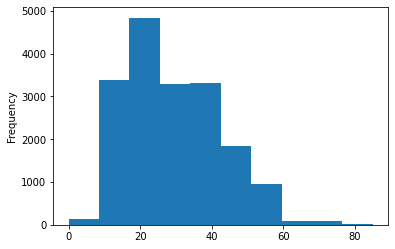

In [66]:
# Посмотрим теперь на гистограмму
data['airports_nearest'].plot(kind='hist')

В основном квартиры отдалены от аэропорты не более чем на 30 км.

#### **cityCenters_nearest** 

23% пропущенных значений, видимо системный сбой. Изучим описание и гистограмму

In [67]:
data['cityCenters_nearest'].describe()

count    17947.000000
mean     14256.130830
std       8603.250197
min        181.000000
25%       9380.000000
50%      13144.000000
75%      16300.000000
max      65968.000000
Name: cityCenters_nearest, dtype: float64

<AxesSubplot:ylabel='Frequency'>

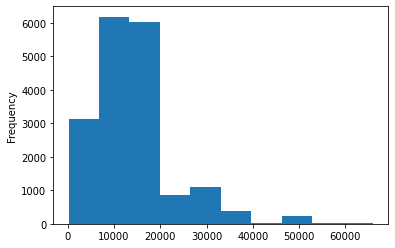

In [68]:
# Посмотрим теперь на гистограмму
data['cityCenters_nearest'].plot(kind='hist')

В основном в выборке квартиры, которые отдалены от центра не более чем на 20 км.

Пропущенные значения планирую заполнить медианными по `locality_name`. Посмотрим на таблицу медианных значений

In [69]:
data.pivot_table(index='locality_name',values='cityCenters_nearest',aggfunc=['median', 'count'])

,median,count
,cityCenters_nearest,cityCenters_nearest
locality_name,,
Зеленогорск,53381.0,24
Колпино,32018.0,337
Красное Село,29148.5,174
Кронштадт,49575.0,95
Ломоносов,51677.0,132
...,...,...
село Путилово,NaN,0
село Рождествено,NaN,0


In [70]:
# Такая же ситуация, как и в предыдущем показателе - отсутствуют многие медианы. Судя по всему это связано с тем, что квартиры 
# в этих местностях единственные
# Часть пропусков заменим медианой, остальные - нулями
data['cityCenters_nearest']=data['cityCenters_nearest'].fillna(data.groupby('locality_name')['cityCenters_nearest'].transform('median'))
data['cityCenters_nearest']=data['cityCenters_nearest'].fillna(0)

In [71]:
# Изменим тип данных на целочисленный
data['cityCenters_nearest']=data['cityCenters_nearest'].astype('int')

In [72]:
# Проверим
data['cityCenters_nearest'].isna().sum()

0

#### **parks_around3000,  ponds_around3000, parks_nearest, ponds_nearest** 

Пропуски в данным столбцах заполню нулями. Так как очевидно, что пропуск означает отсутствие водоемов или парков поблизости
Посмотрим на гистограммы:

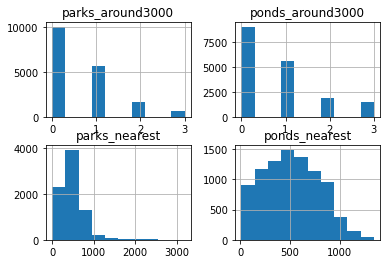

In [73]:
data[['parks_around3000' , 'ponds_around3000', 'parks_nearest', 'ponds_nearest']].hist()
plt.show()

В принципе все логично, квартир, которые рядом с парками и водоемами гораздо меньше, чем без. Такие квартиры и стоят дороже.

In [74]:
# Заполним пропуски нулями
data[['parks_around3000' , 'ponds_around3000', 'parks_nearest', 'ponds_nearest']]=data[['parks_around3000', 'ponds_around3000', 'parks_nearest', 'ponds_nearest']].fillna(0)

In [75]:
# Проверка
data[['parks_around3000' , 'ponds_around3000', 'parks_nearest', 'ponds_nearest']].isna().sum()

parks_around3000    0
ponds_around3000    0
parks_nearest       0
ponds_nearest       0
dtype: int64

Данные параметры имеют тип данных float, хотя по факту относятся к целочисленному типу. Изменим это

In [76]:
data[['parks_around3000' , 'ponds_around3000', 'parks_nearest', 'ponds_nearest']]=data[['parks_around3000' , 'ponds_around3000', 'parks_nearest', 'ponds_nearest']].astype('int')

#### **days_exposition** 

Посмотрим на описание и гистограмму

In [77]:
data['days_exposition'].describe()

count    20298.000000
mean       179.986994
std        219.128809
min          1.000000
25%         45.000000
50%         95.000000
75%        230.000000
max       1580.000000
Name: days_exposition, dtype: float64

<AxesSubplot:>

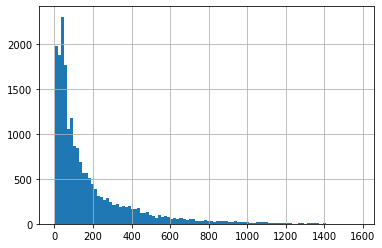

In [78]:
data['days_exposition'].hist(bins=100)

В основном квартиры продаются меньше, чем за 3 месяца(100 дней)

Изменим тип данных на целочисленный для столбцов: `days_exposition`,`last_price`,`floors_total`, а у `first_day_exposition` на 'datetime'

In [79]:
data[['last_price','floors_total']]=data[['last_price','floors_total']].astype('int')
data['first_day_exposition']=pd.to_datetime(data['first_day_exposition'], format=('%Y-%m-%dT%H:%M:%S'))

In [80]:
# Посмотрим на распределение пропусков по годам
pd.pivot_table(data[data['days_exposition'].isna()], index=data['first_day_exposition'].dt.year, values='last_price', aggfunc="count")

,last_price
first_day_exposition,
2014,18
2015,68
2016,65
2017,268
2018,950
2019,1779


Пропусков у нас не мало и с каждым годом их становится все больше. Похоже на технический сбой. Нужно сообщить итишникам.

In [81]:
# Посмотрим, что получилось в итоге предобработки

data.info()
print()
(data.isnull().sum()/data.isnull().count()).transform(lambda x: '{:,.2%}'.format(x))


<class 'pandas.core.frame.DataFrame'>
Int64Index: 23446 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          23446 non-null  int64         
 1   last_price            23446 non-null  int64         
 2   total_area            23446 non-null  float64       
 3   first_day_exposition  23446 non-null  datetime64[ns]
 4   rooms                 23446 non-null  int64         
 5   ceiling_height        23446 non-null  float64       
 6   floors_total          23446 non-null  int64         
 7   living_area           23446 non-null  float64       
 8   floor                 23446 non-null  int64         
 9   is_apartment          23446 non-null  bool          
 10  studio                23446 non-null  bool          
 11  open_plan             23446 non-null  bool          
 12  kitchen_area          23446 non-null  float64       
 13  balcony         

total_images             0.00%
last_price               0.00%
total_area               0.00%
first_day_exposition     0.00%
rooms                    0.00%
ceiling_height           0.00%
floors_total             0.00%
living_area              0.00%
floor                    0.00%
is_apartment             0.00%
studio                   0.00%
open_plan                0.00%
kitchen_area             0.00%
balcony                  0.00%
locality_name            0.00%
airports_nearest        23.54%
cityCenters_nearest      0.00%
parks_around3000         0.00%
parks_nearest            0.00%
ponds_around3000         0.00%
ponds_nearest            0.00%
days_exposition         13.43%
dtype: object

In [82]:
# Посмотрим какой % дпнных у нас остался после предобработки
len(data)/len(data_init)*100

98.93244440693701

#### **Вывод:** 
Для более качественного проведения анализа было принято решение удалить очень дорогие квартиры(0,5%) и строки, в которых пропущены значения в locality_name. Всего было удалено менее 1% данных.
Пропущенные или аномальные значения были заменены либо на медианные, где была возможность, либо на нули, либо домножены(разделены) на какое-то число, так как есть подозрения на ошибку в значениях при вводе данных.
Были убраны 41 дубликат из locality_name.
Были подправлены типы данных некоторых переменных.
В итоге осталось 98% данных от изначальной выборки.

### Посчитайте и добавьте в таблицу новые столбцы

In [83]:
# Добавим столбец цена одного кв.метра
data['sq_price']=(data['last_price']/data['total_area']).round(2)
data.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,sq_price
0,20,13000000,108.0,2019-03-07,3,2.70,16,51.0,8,False,False,False,25.0,0,Санкт-Петербург,19.0,16028,1,482,2,755,NaN,120370.37
1,7,3350000,40.4,2018-12-04,1,2.65,11,18.6,1,False,False,False,11.0,2,посёлок Шушары,13.0,18603,0,0,0,0,81.0,82920.79
2,10,5196000,56.0,2015-08-20,2,2.65,5,34.3,4,False,False,False,8.3,0,Санкт-Петербург,22.0,13933,1,90,2,574,558.0,92785.71
4,2,10000000,100.0,2018-06-19,2,3.03,14,32.0,13,False,False,False,41.0,0,Санкт-Петербург,32.0,8098,2,112,1,48,121.0,100000.00
5,10,2890000,30.4,2018-09-10,1,2.65,12,14.4,5,False,False,False,9.1,0,городской посёлок Янино-1,NaN,0,0,0,0,0,55.0,95065.79


In [84]:
# Добавим столбец день недели публикации (где 0 - понедельник и т.д.)
data['week_day_exposition']=data['first_day_exposition'].dt.weekday

In [85]:
# Добавим столбец месяц публикации
data['month_exposition']=data['first_day_exposition'].dt.month

In [86]:
# Добавим столбец год публикации
data['year_exposition']=data['first_day_exposition'].dt.year

In [87]:
# Добавим столбец для категоризации этажа квартиры
# Для этого создадим функцию категоризации
data=data.reset_index(drop=True)
def floor_category(row):
    if row['floor']==1:
        return 'первый'
    elif row['floor']==row['floors_total']:
        return 'последний'
    return 'другой'
    
data['floor_cat']=data.apply(floor_category,axis=1)

In [88]:
data['cityCenters_nearest_km']=(data['cityCenters_nearest']/1000).round(0).astype('int')
data.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,sq_price,week_day_exposition,month_exposition,year_exposition,floor_cat,cityCenters_nearest_km
0,20,13000000,108.0,2019-03-07,3,2.70,16,51.0,8,False,False,False,25.0,0,Санкт-Петербург,19.0,16028,1,482,2,755,NaN,120370.37,3,3,2019,другой,16
1,7,3350000,40.4,2018-12-04,1,2.65,11,18.6,1,False,False,False,11.0,2,посёлок Шушары,13.0,18603,0,0,0,0,81.0,82920.79,1,12,2018,первый,19
2,10,5196000,56.0,2015-08-20,2,2.65,5,34.3,4,False,False,False,8.3,0,Санкт-Петербург,22.0,13933,1,90,2,574,558.0,92785.71,3,8,2015,другой,14
3,2,10000000,100.0,2018-06-19,2,3.03,14,32.0,13,False,False,False,41.0,0,Санкт-Петербург,32.0,8098,2,112,1,48,121.0,100000.00,1,6,2018,другой,8
4,10,2890000,30.4,2018-09-10,1,2.65,12,14.4,5,False,False,False,9.1,0,городской посёлок Янино-1,NaN,0,0,0,0,0,55.0,95065.79,0,9,2018,другой,0


### Проведите исследовательский анализ данных
#### Часть 1

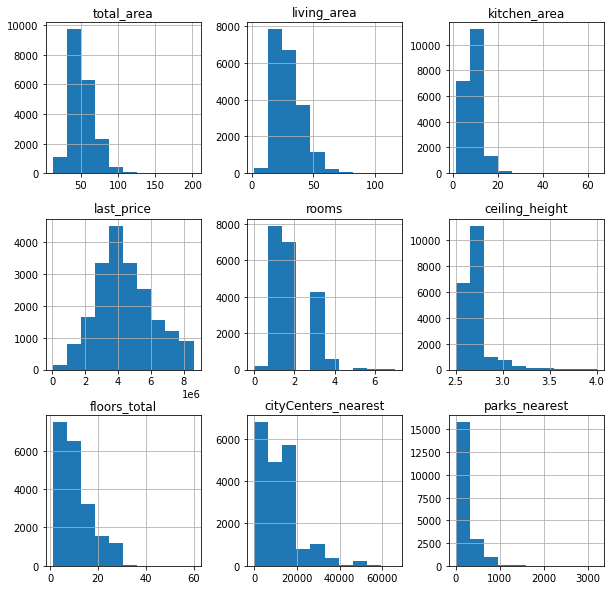

In [89]:
# построим гистограммы, взяв среднюю выборку квартир, которые дешевле 85 процентиля цены для того, чтобы более приблизится к средним значениям.
data[data['last_price']<=data['last_price'].quantile(0.85)][['total_area','living_area','kitchen_area','last_price','rooms','ceiling_height','floor_cat','floors_total','cityCenters_nearest','parks_nearest']].hist(figsize=(10,10))
plt.show()
    

Вывод: В среднем квартиры размером не более 50 кв.м, с кухней около 10 кв.м, гостиной около 20 кв.м, до 2-х комнат, с высотой потолков до 2.75, в доме с этажностью до 10, до центра города до 20 км, до ближайшего парка до 500 м и с ценой 4 млн.

#### Часть 2 - Исследование зависимостей

count    20298.000000
mean       179.986994
std        219.128809
min          1.000000
25%         45.000000
50%         95.000000
75%        230.000000
max       1580.000000
Name: days_exposition, dtype: float64


<AxesSubplot:ylabel='Frequency'>

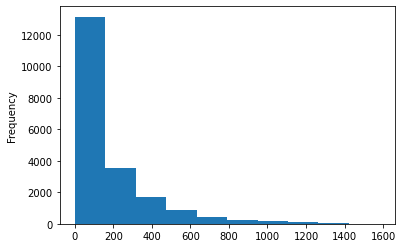

In [90]:
# Исследуем параметр days_exposition
print(data['days_exposition'].describe())
data['days_exposition'].plot(kind='hist')

В среднем(медиана) квартира продается за 73 дня. Продажи быстрее 22 дней я бы назвала очень быстрыми, а дольше 197 - очень долгими

<AxesSubplot:>

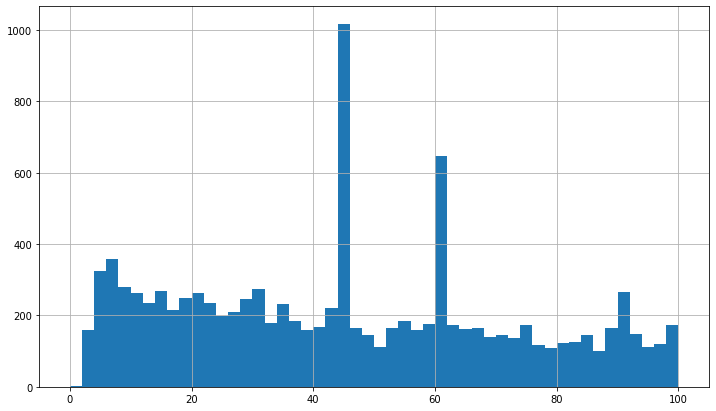

In [91]:
# Код ревьюера
data['days_exposition'].hist(bins=50, range=(0,100), figsize=(12, 7))

                     last_price  total_area  living_area  kitchen_area  \
last_price             1.000000    0.779574     0.694939      0.620339   
total_area             0.779574    1.000000     0.940615      0.627416   
living_area            0.694939    0.940615     1.000000      0.446529   
kitchen_area           0.620339    0.627416     0.446529      1.000000   
week_day_exposition   -0.017990   -0.012783    -0.010683     -0.009338   
month_exposition       0.004513    0.006439     0.001506      0.006678   
year_exposition       -0.043643   -0.077058    -0.067948     -0.055193   

                     week_day_exposition  month_exposition  year_exposition  
last_price                     -0.017990          0.004513        -0.043643  
total_area                     -0.012783          0.006439        -0.077058  
living_area                    -0.010683          0.001506        -0.067948  
kitchen_area                   -0.009338          0.006678        -0.055193  
week_day_expositi

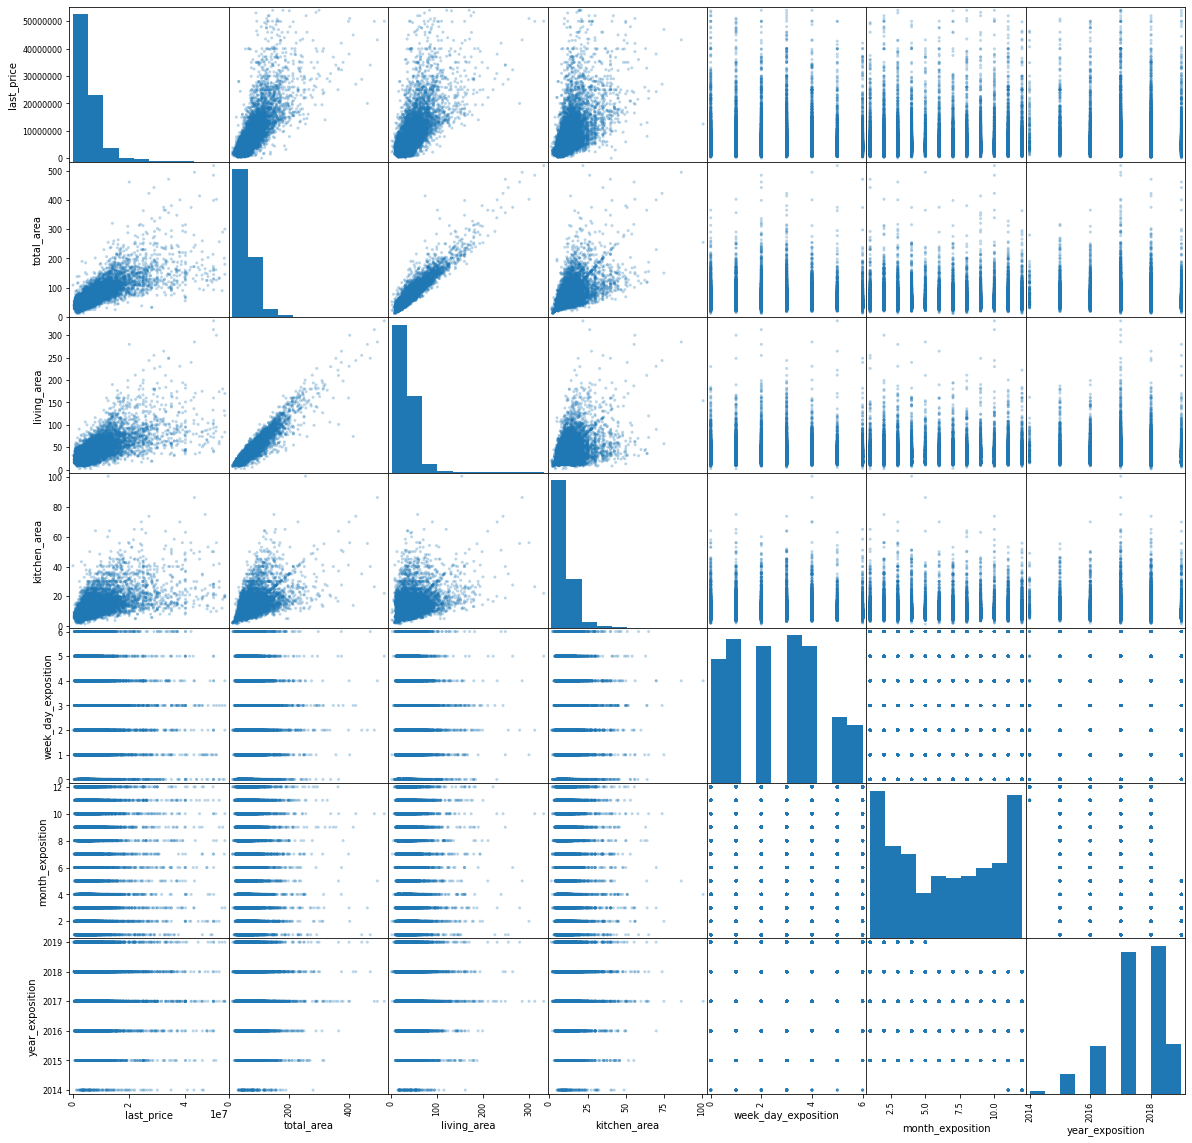

In [92]:
# изучим зависимость цены от некоторых факторов
print(data[['last_price','total_area', 'living_area', 'kitchen_area', 'floor_cat', 'week_day_exposition', 'month_exposition', 'year_exposition']].corr())
pd.plotting.scatter_matrix(data[['last_price','total_area', 'living_area', 'kitchen_area','week_day_exposition', 'month_exposition', 'year_exposition']], figsize=(20,20), alpha=0.3)
plt.show()


<AxesSubplot:xlabel='floor_cat', ylabel='last_price'>

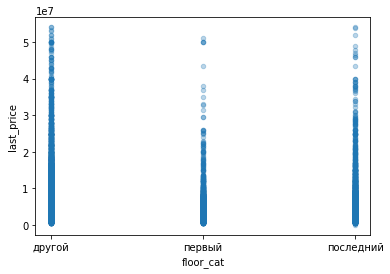

In [93]:
data.plot(x='floor_cat', y='last_price', kind='scatter', alpha=0.3)

Вывод: 
- цена на жилье имеет прямую линейную зависимость от общего размера квартиры и размера гостиной. Зависимость цены от размера кухни хоть и напоминает прямую линейную зависимость, однако менее выражено. Скорее всего, размер кухни имеет небольшое влияние на ценообразование.
- Заметно, что в четверг продается немного больше квартир, чем в другие дни, а также больше продается более дорогих квартир
- В феврале и ноябре продается больше дорогих квартир, чем в остальные месяцы
- В 2017 году больше продано более дорогих квартир
- Больше ценятся квартиры на последнем этаже в сравнении с первым этажом


In [94]:
# Построим сводную таблицу(кол-во обьявлений и стоимость квадратного метра) для 10 населенных пунктов с наибольшим кол-вом обьявлений
region_grouped=pd.pivot_table(data,index='locality_name', values= 'sq_price', aggfunc={'sq_price':['median','count']})
region_grouped=region_grouped.sort_values(by=('count'), ascending=False).head(10)
region_grouped.columns=['кол-во обьявлений', 'ср.стоимость кв.м.']
region_grouped

,кол-во обьявлений,ср.стоимость кв.м.
locality_name,,
Санкт-Петербург,15532,104545.450
посёлок Мурино,552,86059.295
посёлок Шушары,439,76829.270
Всеволожск,398,65789.470
Пушкин,369,100000.000
Колпино,338,74723.745
посёлок Парголово,327,91642.860
Гатчина,307,67796.610
деревня Кудрово,299,91860.470


Самые дорогие квартиры в Санкт-Петербурге, 105 тыс за кв.м, а самые дешевые в Выборге - 58 тыс. за кв.м.

In [95]:
# Найдем среднюю цену каждого километра до центра в г. Санкт-Петербург
St_Peterburg_km_price=data.query('locality_name=="Санкт-Петербург"').pivot_table(index='cityCenters_nearest_km', values='last_price', aggfunc='median')
St_Peterburg_km_price

,last_price
cityCenters_nearest_km,
0,13500000
1,10685000
2,9750000
3,8400000
4,9125000
5,9225000
6,8600000
7,7500000
8,7400000


<AxesSubplot:xlabel='cityCenters_nearest_km'>

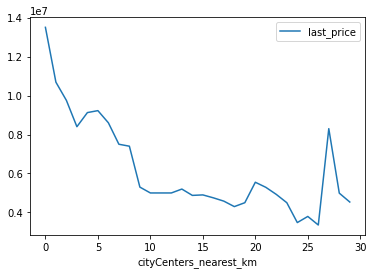

In [96]:
St_Peterburg_km_price.plot()

Заметно, что расстояние до центра очень влияет на цену квартир в Санкт-Петербурге

### Общий вывод

Был проведен анализ датасета обьявлений о продажах квартир в Санкт-Петербурге и соседних населённых пунктах за несколько лет.<br><br>
**Первый этап - Предобработка данных:** 
удалены очень дорогие квартиры(0,5%) и строки, в которых пропущены значения в locality_name. Всего было удалено менее 1% данных.
Пропущенные или аномальные значения были заменены либо на медианные, где была возможность, либо на нули, либо домножены(разделены) на какое-то число, так как есть подозрения на ошибку в значениях при вводе данных.
Были убраны 41 дубликат из locality_name.
Были подправлены типы данных некоторых переменных.<br><br>
**Второй этап - анализ данных:**
добавлены столбцы: <br>    
1) цена одного квадратного метра;<br>
2) день недели публикации объявления (0 — понедельник, 1 — вторник и так далее);<br>
3) месяц публикации объявления;<br>
4) год публикации объявления;<br>
5) тип этажа квартиры (значения — «первый», «последний», «другой»);<br>
6) расстояние до центра города в километрах.<br><br>
Проанализировано влияние некоторых параметров на цену жилья:
- Цена на жилье имеет прямую линейную зависимость от общего размера квартиры и размера гостиной. Зависимость цены от размера кухни хоть и напоминает прямую линейную зависимость, однако менее выражено. Скорее всего, размер кухни имеет небольшое влияние на ценообразование.
- Заметно, что в четверг продается немного больше квартир, чем в другие дни, а также больше продается более дорогих квартир
- В феврале и ноябре продается больше дорогих квартир, чем в остальные месяцы
- В 2017 году больше продано более дорогих квартир
- Больше ценятся квартиры на последнем этаже в сравнении с первым этажом
- Самые дорогие квартиры в Санкт-Петербурге, 105 тыс за кв.м, а самые дешевые в Выборге - 58 тыс. за кв.м.
- Расстояние до центра прямо влияет на цену квартир в Санкт-Петербурге.